In [1]:
# Code Library/Packages:
import types
import pkg_resources
import gc
import tqdm as tqdm
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.nn import functional as F
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy, auroc
import pytorch_lightning as pl

# Processing Device(s):
processing_device= "cuda" if torch.cuda.is_available() else "cpu"
torch_aval = torch.cuda.is_available()

def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

# Set data paths:
IN=r'E:\random_data\in'
OUT=r'E:\random_data\out'

print("----------------------------------------------------")
print("###               VERSION TYPES                  ###")
print("----------------------------------------------------")
print(f"Versions: ", requirements)
print(f"Device(s) to Utilize: ", processing_device)
print(f"Is Torch Availabke?: ", torch_aval)
print(f"# of Devices Found: ", torch.__version__)
print("----------------------------------------------------")
print(f"If NVIDIA-SMI is not found, then CUDA isn't available on this device:")
!nvidia-smi
gc.collect()
print("----------------------------------------------------")
print(f"Clear Torch Cuda Memory: ", torch.cuda.empty_cache())
print("-----ENVIRONMENT IS COMPLETE & STAGED CORRECTLY-----")

c:\DatSci\Code\Python\3.10.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\DatSci\Code\Python\3.10.9\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\DatSci\Code\Python\3.10.9\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


----------------------------------------------------
###               VERSION TYPES                  ###
----------------------------------------------------
Versions:  [('Pillow', '9.3.0'), ('tqdm', '4.64.1'), ('matplotlib', '3.6.2'), ('numpy', '1.23.5'), ('torch', '1.13.0'), ('pandas', '1.5.2'), ('torchvision', '0.14.0+cu117'), ('opendatasets', '0.1.22')]
Device(s) to Utilize:  cpu
Is Torch Availabke?:  False
# of Devices Found:  1.13.0+cpu
----------------------------------------------------
If NVIDIA-SMI is not found, then CUDA isn't available on this device:
Sat Dec 10 12:42:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M.

In [3]:
cancer_labels = pd.read_csv(IN + r'\histopathologic-cancer-detection\histopathologic-cancer-detection\train_labels.csv')
cancer_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


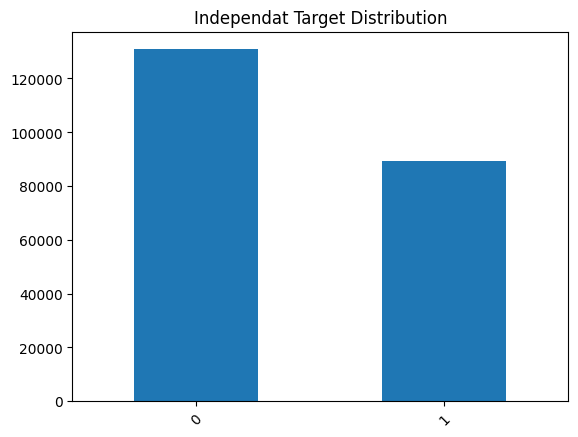

In [4]:
cancer_labels.label.value_counts().plot(kind="bar")
plt.title("Independat Target Distribution")
plt.xticks(rotation=45)
plt.show()

In [6]:
APP_FOLDER = IN + r'\histopathologic-cancer-detection\histopathologic-cancer-detection'
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  E:\random_data\in\histopathologic-cancer-detection\histopathologic-cancer-detection
Searching in :  E:\random_data\in\histopathologic-cancer-detection\histopathologic-cancer-detection\test
Searching in :  E:\random_data\in\histopathologic-cancer-detection\histopathologic-cancer-detection\train
Total number of files 277485
Total Number of directories 2
Total: 277487


In [8]:
np.random.seed(0)

train_imgs_orig = os.listdir(IN + r'\histopathologic-cancer-detection\histopathologic-cancer-detection\train')

selected_image_list = []

for img in np.random.choice(train_imgs_orig, 10000):
 selected_image_list.append(img)
len(selected_image_list)

10000

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\random_data\\in\\histopathologic-cancer-detection\\histopathologic-cancer-detection\\train64e491dfdca34733d41623b15157398ee4cf3a12.tif'

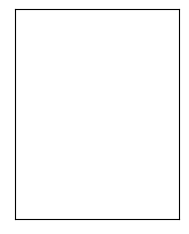

In [18]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(IN + r'\histopathologic-cancer-detection\histopathologic-cancer-detection\train' + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [15]:
np.random.seed(0)
np.random.shuffle(selected_image_list)

cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]

print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000
